## Clasificación de los dígitos de Mnist en forma de set de puntos

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils import chamfer_loss
from fspool import FSPool
from fspool import cont_sort
from model import FSEncoder
from model import FSEncoderClasification
from MnistSet import MNISTSet
from MnistSet import get_loader

### Preparamos los datos de entreno y test

In [2]:
batch_size = 32

In [3]:
train_loader = get_loader(
            MNISTSet(train=True, full=True), batch_size=batch_size, num_workers=4)

In [4]:
test_loader = get_loader(
            MNISTSet(train=False, full=True), batch_size=batch_size, num_workers=4)

In [5]:
from time import sleep
from tqdm import tqdm

In [6]:
set_channels = 2
set_size = 342
  
hidden_dim = 32
iters = 10
latent_dim = 16
lr = 0.001
n_epochs = 10
net = FSEncoderClasification(set_channels,latent_dim,hidden_dim)

In [7]:
optimizer = torch.optim.Adam([p for p in net.parameters() if p.requires_grad], lr=0.001)

In [ ]:
net = net.cuda()

In [ ]:
net.train()
for epoch in range(n_epochs):
    with tqdm(train_loader, unit="batch") as tepoch:
        for i, sample in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            input, target_set, target_mask = map(lambda x: x.cuda(), sample)
            optimizer.zero_grad()
            output = net(target_set,target_mask)
            loss = F.cross_entropy(output, input)
            acc = (output.max(dim=1)[1] == input).float().mean()
            loss.backward()
            optimizer.step()
            tepoch.set_postfix(loss=loss.item(), acc=100. * acc.item())

In [ ]:
net.eval()
with tqdm(test_loader, unit="batch") as tepoch:
    for i, sample in enumerate(tepoch):
        tepoch.set_description(f"Epoch {1}")
        input, target_set, target_mask = map(lambda x: x.cuda(), sample)
        output = net(target_set,target_mask)
        loss = F.cross_entropy(output, input)
        acc = (output.max(dim=1)[1] == input).float().mean()
        tepoch.set_postfix(loss=loss.item(), acc=100. * acc.item())

In [ ]:
#torch.save(net.state_dict(),'model.pth')

In [8]:
model = torch.load('model.pth' ,map_location=torch.device('cpu'))
miNet = FSEncoderClasification(set_channels,latent_dim,hidden_dim)

In [9]:
miNet.load_state_dict(torch.load('model.pth' ,map_location=torch.device('cpu')))

<All keys matched successfully>

In [10]:
miNet = miNet
miNet.eval()
with tqdm(test_loader, unit="batch") as tepoch:
    for i, sample in enumerate(tepoch):
        tepoch.set_description(f"Epoch {0}")
        input, target_set, target_mask = map(lambda x: x, sample)
        output = miNet(target_set,target_mask)
        loss = F.cross_entropy(output, input)
        acc = (output.max(dim=1)[1] == input).float().mean()
        tepoch.set_postfix(loss=loss.item(), acc=100. * acc.item())

Epoch 0: 100%|███████| 312/312 [07:58<00:00,  1.53s/batch, acc=93.8, loss=0.264]


In [11]:
miNet

FSEncoderClasification(
  (conv): Sequential(
    (0): Conv1d(2, 32, kernel_size=(1,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
  )
  (lin): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
  (pool): FSPool()
)

## Visualización de los filtros

In [12]:
import seaborn as sn
import matplotlib
import matplotlib.pyplot as pyplot
import numpy as np

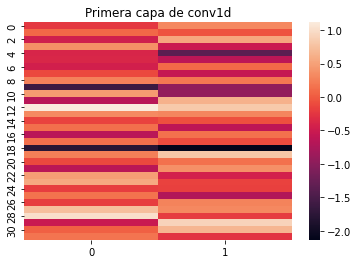

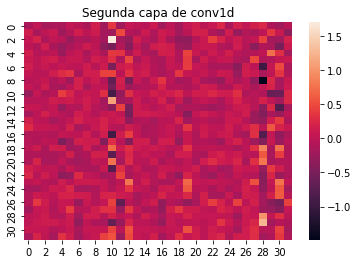

In [13]:
filters= miNet.conv[0].weight
data = filters.squeeze(2).detach().numpy()
sn.heatmap(data, annot=False, fmt='g')
pyplot.title("Primera capa de conv1d")
pyplot.show()
filters= miNet.conv[2].weight
data = filters.squeeze(2).detach().numpy()
sn.heatmap(data, annot=False, fmt='g')
pyplot.title("Segunda capa de conv1d")
pyplot.show()

torch.Size([32, 21])


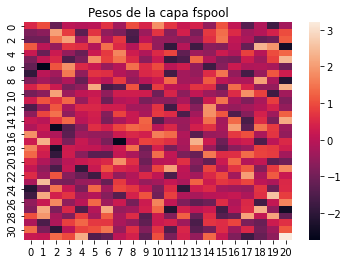

In [14]:
filters= miNet.pool.weight
print(filters.shape)
data = filters.detach().numpy()
sn.heatmap(data, annot=False, fmt='g')
pyplot.title("Pesos de la capa fspool")
pyplot.show()

torch.Size([32, 32])


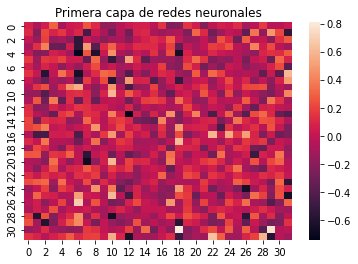

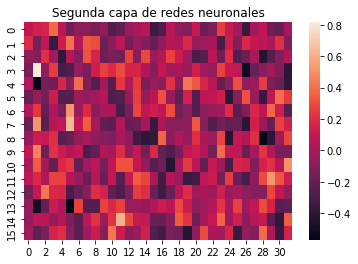

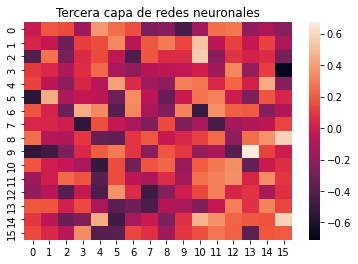

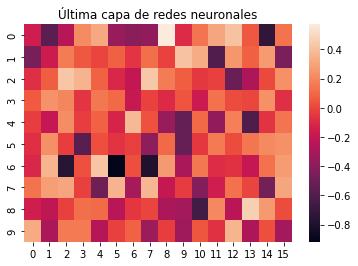

In [15]:
filters= miNet.lin[0].weight
print(filters.shape)
data = filters.detach().numpy()
sn.heatmap(data, annot=False, fmt='g')
pyplot.title("Primera capa de redes neuronales")
pyplot.show()
filters= miNet.lin[2].weight
data = filters.detach().numpy()
sn.heatmap(data, annot=False, fmt='g')
pyplot.title("Segunda capa de redes neuronales")
pyplot.show()
filters= miNet.classifier[0].weight
data = filters.detach().numpy()
sn.heatmap(data, annot=False, fmt='g')
pyplot.title("Tercera capa de redes neuronales")
pyplot.show()
filters= miNet.classifier[2].weight
data = filters.detach().numpy()
sn.heatmap(data, annot=False, fmt='g')
pyplot.title("Última capa de redes neuronales")
pyplot.show()

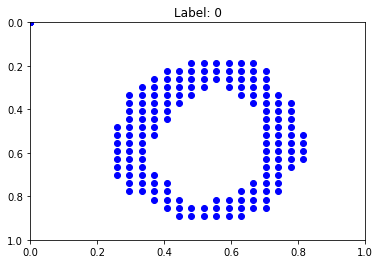

torch.Tensor

In [16]:
dataset = MNISTSet(train=False, full=True)
expected, sample,mask_sample = dataset[13]
x = sample[1, :]
y = sample[0, :]
pyplot.scatter(x, y,color ='b')
pyplot.axis([0, 1, 1, 0])
pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()
sample = sample.unsqueeze(0)
mask_sample = mask_sample.unsqueeze(0)
expected = torch.tensor(expected).unsqueeze(0)
type(sample)


In [17]:
with torch.no_grad():
    pred = miNet(sample,mask_sample)
    print("We obtained {}, and the expected is: {}".format(np.argmax(pred).item(),expected.item()))

We obtained 0, and the expected is: 0


In [18]:
#Creación del modelo pre-fspooling
class Model1(nn.Module):
    def __init__(self, input_channels, output_channels, dim):
        super().__init__()
        for m in self.modules():
            if (
                isinstance(m, nn.Linear)
                or isinstance(m, nn.Conv2d)
                or isinstance(m, nn.Conv1d)
            ):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()
        self.conv = nn.Sequential(
            nn.Conv1d(input_channels, dim, 1),
            nn.ReLU(inplace=True),
            nn.Conv1d(dim, dim, 1),
        )
        #self.conv[0] = miNet.conv[0].weight
        #self.conv[2] = miNet.conv[2].weight
        #self.lin = self.lin.fill_(miNet.lin.weight)
        #self.classifier = self.classifier.fill_(miNet.classifier.weight)
        #self.pool = FSPool(dim, 20, relaxed=False)

    def forward(self, x, mask=None):
        x = self.conv(x)
        #x, perm = self.pool(x)
        #x = self.lin(x)
        #x = self.classifier(x)
        return x
#Creación del modelo post-fspooling

In [19]:
#Creación del modelo pre-fspooling
class Model2(nn.Module):
    def __init__(self, input_channels, output_channels, dim):
        super().__init__()
        for m in self.modules():
            if (
                isinstance(m, nn.Linear)
                or isinstance(m, nn.Conv2d)
                or isinstance(m, nn.Conv1d)
            ):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()
        self.conv = nn.Sequential(
            nn.Conv1d(input_channels, dim, 1),
            nn.ReLU(inplace=True),
            nn.Conv1d(dim, dim, 1),
        )
        #self.conv[0] = miNet.conv[0].weight
        #self.conv[2] = miNet.conv[2].weight
        #self.lin = self.lin.fill_(miNet.lin.weight)
        #self.classifier = self.classifier.fill_(miNet.classifier.weight)
        self.pool = FSPool(dim, 20, relaxed=True)

    def forward(self, x, mask=None):
        #print(x)
        x = self.conv(x)
        x, perm = self.pool(x)
        #x = self.lin(x)
        #x = self.classifier(x)
        return x,perm
#Creación del modelo post-fspooling

In [20]:
pre_fspool = miNet.conv
pre_fspool

Sequential(
  (0): Conv1d(2, 32, kernel_size=(1,), stride=(1,))
  (1): ReLU(inplace=True)
  (2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
)

In [21]:
post_fspool = miNet.pool
post_fspool

FSPool()

## Visualización de los puntos críticos

torch.Size([1, 32, 342])


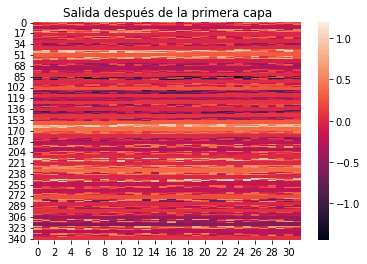

El tamaño de la mascara. torch.Size([1, 32])
[ -3.172934     3.8099504    8.067993   -14.81385    -11.466012
  -0.48138753  -1.734562    -1.1938038   -2.8493123   -1.6328917
  -2.2209282    1.873779    -0.0870605    3.860637    -0.27741098
  -8.784897    -3.6824803   11.90331      0.27814573  -5.2751427
  -4.5594015    2.2490604  -11.844124    -1.5144867   -1.6505135
  -0.5213829    8.342564     3.8406575    3.1326146    0.2985373
   0.34591287  15.252356  ]


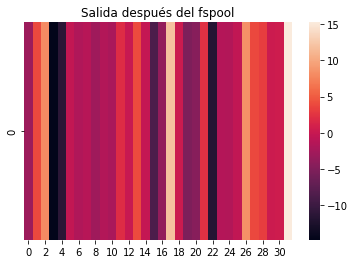

torch.Size([1, 32, 342])
ESTE ES EL UNPOOL


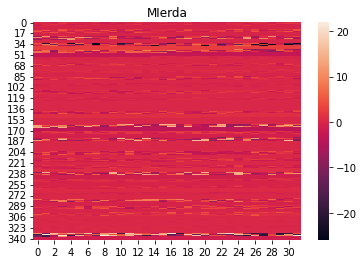

In [22]:
model1 = Model1(set_channels,latent_dim,hidden_dim)
model2 = Model2(set_channels,latent_dim,hidden_dim)
model1.conv = pre_fspool
model2.conv = pre_fspool
model2.pool = post_fspool

#print(miNet.conv[0].weight) 
#print(model1.conv[0].weight)
with torch.no_grad():
    
    pred = model1(sample,mask_sample)
    print(pred.shape)
    #print(pred)
    nfeatures_pred = pred.detach()
    data = pred.squeeze(0).detach().view(342,32).numpy()
    datakk = data
    sn.heatmap(data, annot=False, fmt='g')
    pyplot.title("Salida después de la primera capa")
    pyplot.show()
    
    pred,perm = model2(sample,mask_sample)
    print("El tamaño de la mascara. {}".format(pred.shape))
    mapa_de_fspool = pred
    fspool_salida = pred.squeeze(0).detach().numpy()
    print(fspool_salida)
    data = pred.detach().numpy()
    sn.heatmap(data, annot=False, fmt='g')
    pyplot.title("Salida después del fspool")
    pyplot.show()
    #print(pred)
    kk,maskara = model2.pool.forward_transpose(pred,perm)
    nfeatures = kk
    print(kk.shape)
    print("ESTE ES EL UNPOOL")
    data = kk.squeeze(0).detach().view(342,32).numpy()
    dataInutil = kk.squeeze(0).detach().numpy()
    sn.heatmap(data, annot=False, fmt='g')
    pyplot.title("MIerda")
    pyplot.show()

In [23]:
print(fspool_salida)

[ -3.172934     3.8099504    8.067993   -14.81385    -11.466012
  -0.48138753  -1.734562    -1.1938038   -2.8493123   -1.6328917
  -2.2209282    1.873779    -0.0870605    3.860637    -0.27741098
  -8.784897    -3.6824803   11.90331      0.27814573  -5.2751427
  -4.5594015    2.2490604  -11.844124    -1.5144867   -1.6505135
  -0.5213829    8.342564     3.8406575    3.1326146    0.2985373
   0.34591287  15.252356  ]


In [24]:
print(model2.pool.ahmed.sum(dim=2).numpy())

[[ -3.172934     3.8099504    8.067993   -14.81385    -11.466012
   -0.48138753  -1.734562    -1.1938038   -2.8493123   -1.6328917
   -2.2209282    1.873779    -0.0870605    3.860637    -0.27741098
   -8.784897    -3.6824803   11.90331      0.27814573  -5.2751427
   -4.5594015    2.2490604  -11.844124    -1.5144867   -1.6505135
   -0.5213829    8.342564     3.8406575    3.1326146    0.2985373
    0.34591287  15.252356  ]]


In [25]:
print(model2.pool.ahmed.argmax(2)[0])

tensor([ 17,  34,  45, 341, 119,  85, 341, 290, 341,  85, 324, 341, 341, 273,
        324, 273,   0, 307,   0,   0,   0, 187,  34,  17,  34,  17, 307, 341,
        256, 221,   0,  34])


In [26]:
print(model2.pool.ahmed)
x = model2.pool.ahmed.clone()
x.shape

tensor([[[ 0.2143,  0.2270,  0.2394,  ...,  0.1127,  0.0943,  0.0758],
         [-0.5753, -0.5640, -0.5527,  ..., -0.2367, -0.2484, -0.2602],
         [-0.5194, -0.5086, -0.4972,  ..., -0.2542, -0.2922, -0.3308],
         ...,
         [-0.1229, -0.1756, -0.2273,  ..., -0.3416, -0.3544, -0.3671],
         [ 1.0487,  0.9425,  0.8372,  ..., -0.2344, -0.2560, -0.2777],
         [ 0.0897,  0.0880,  0.0864,  ..., -1.1067, -1.2053, -1.3047]]])


torch.Size([1, 32, 342])

In [27]:
x,_ = cont_sort(x,perm)
ojo = x.sum(dim=2).clone()
ojopiojo = np.sort(ojo)
print(ojopiojo)

[[-14.813847   -11.844123   -11.466009    -8.784914    -5.2751436
   -4.559402    -3.6824808   -3.1729405   -2.849314    -2.2209284
   -1.7345628   -1.650512    -1.6328906   -1.514482    -1.1938034
   -0.5213814   -0.48138773  -0.2774148   -0.08706117   0.27814585
    0.29853368   0.34591228   1.8737797    2.2490516    3.1326103
    3.809949     3.8406568    3.860638     8.06799      8.342562
   11.903314    15.252356  ]]


In [28]:
maxes = model2.pool.ahmed.argmin(2)[0].squeeze(0).numpy()
mines = model2.pool.ahmed.argmax(2)[0].squeeze(0).numpy()

In [29]:
points = sample.squeeze(0).numpy()
critical_points_ahmed_x = []
critical_points_ahmed_y = []
for k in range(len(maxes)):
    critical_points_ahmed_y.append(points[0,maxes[k]])
    critical_points_ahmed_x.append(points[1,maxes[k]])
for k in range(len(mines)):
    critical_points_ahmed_y.append(points[0,mines[k]])
    critical_points_ahmed_x.append(points[1,mines[k]])
#criticos = critical_points.reshape(2,100)
#print(critical_points_x)
print(len(critical_points_ahmed_x))

64


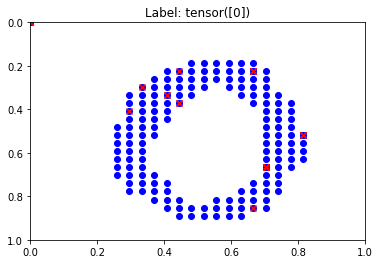

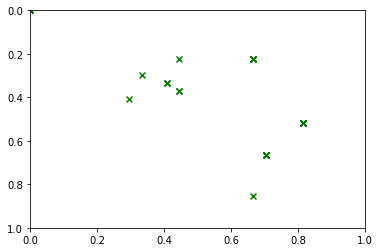

In [30]:
sam = sample.squeeze(0).numpy()
x = sam[1, :]
y = sam[0, :]
pyplot.scatter(x, y,color ='b')
x2 = critical_points_ahmed_x
y2 = critical_points_ahmed_y
pyplot.scatter(x2, y2,marker='x',color ='r')
pyplot.axis([0, 1, 1, 0])
pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()

x2 = critical_points_ahmed_x
y2 = critical_points_ahmed_y
pyplot.scatter(x2, y2,marker='x',color ='g')
pyplot.axis([0, 1, 1, 0])
pyplot.show()

In [43]:
maxes = model2.pool.truco.argmin(2)[0].squeeze(0).numpy()
mines = model2.pool.truco.argmax(2)[0].squeeze(0).numpy()

In [44]:
points = sample.squeeze(0).numpy()
critical_points_ahmed_x = []
critical_points_ahmed_y = []
for k in range(len(maxes)):
    critical_points_ahmed_y.append(points[0,maxes[k]])
    critical_points_ahmed_x.append(points[1,maxes[k]])
for k in range(len(mines)):
    critical_points_ahmed_y.append(points[0,mines[k]])
    critical_points_ahmed_x.append(points[1,mines[k]])
#criticos = critical_points.reshape(2,100)
#print(critical_points_x)
print(len(critical_points_ahmed_x))

64


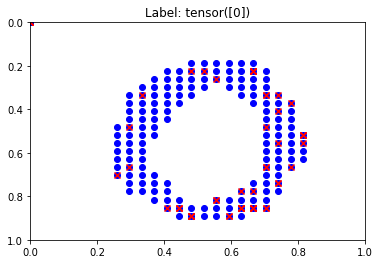

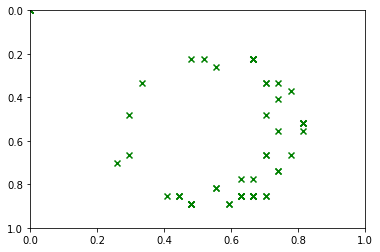

In [45]:
sam = sample.squeeze(0).numpy()
x = sam[1, :]
y = sam[0, :]
pyplot.scatter(x, y,color ='b')
x2 = critical_points_ahmed_x
y2 = critical_points_ahmed_y
pyplot.scatter(x2, y2,marker='x',color ='r')
pyplot.axis([0, 1, 1, 0])
pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()

x2 = critical_points_ahmed_x
y2 = critical_points_ahmed_y
pyplot.scatter(x2, y2,marker='x',color ='g')
pyplot.axis([0, 1, 1, 0])
pyplot.show()

La problematica aqui es que con la operación del fspool, lo que se hace es coger y aplicarle al tensor de entrada de [1,32,342] unos pesos (de los cuales supuestamente salen de hacer una interpolación) y una vez que se realiza dicho producto, se suma la dimensión 2.
A la hora de hacer el unpooling, no se hace del todo debido a que creo que el código esta mal o algo, ya que lo que hace es coger el tensor fspool, y aplicarle nuevamente el vector de pesos(?), cosa que creo que esta mal y que lo mas conveniente sería aplicarle la inversa de dichos pesos 

In [ ]:
miNet.pool.ahmed

In [ ]:
with torch.no_grad():
    pool = FSPool(2, 1,True)
    x = torch.arange(0, 2*3*4).view(3, 2, 4).float()
    print('x', x)
    y, perm = pool(x)
    print('perm')
    print(perm)
    print('result')
    print(y.sum())
    z,m = pool.forward_transpose(y,perm)
    print(z)
    tensorFspool = x[0]
    print(tensorFspool)
    print(pool.forward(tensorFspool))